In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thesisInitial.cleaning_data import extract_data_from_house, extract_rated_power, extract_average_time_on, apply_new_load
import thesisInitial.tariff as tf

sns.set()

In [2]:
house_id = 64613
data = extract_data_from_house(house_id)
rated_power = extract_rated_power(data.load)
average_duration = extract_average_time_on(data.load)
data.head()

reading_datetime
2019-01-01 00:00:00    False
2019-01-01 00:05:00    False
2019-01-01 00:10:00    False
2019-01-01 00:15:00    False
2019-01-01 00:20:00    False
                       ...  
2019-12-31 23:35:00    False
2019-12-31 23:40:00    False
2019-12-31 23:45:00    False
2019-12-31 23:50:00    False
2019-12-31 23:55:00    False
Name: load, Length: 105053, dtype: bool
reading_datetime
2019-01-01 00:00:00    False
2019-01-01 00:05:00    False
2019-01-01 00:10:00    False
2019-01-01 00:15:00    False
2019-01-01 00:20:00    False
                       ...  
2019-12-31 23:35:00    False
2019-12-31 23:40:00    False
2019-12-31 23:45:00    False
2019-12-31 23:50:00    False
2019-12-31 23:55:00    False
Length: 105053, dtype: bool


,load,PV,AC,total_use,grid_import,grid_export
reading_datetime,,,,,,
2019-01-01 00:00:00,0.0194,-0.0733,70.0850,70.0311,70.1044,0.0
2019-01-01 00:05:00,0.0197,-0.0736,69.2019,69.1480,69.2216,0.0
2019-01-01 00:10:00,0.0192,-0.0728,66.6908,66.6372,66.7100,0.0
2019-01-01 00:15:00,0.0194,-0.0733,68.1369,68.0830,68.1563,0.0
2019-01-01 00:20:00,0.0225,-0.0742,81.0847,81.0330,81.1072,0.0


In [3]:
median_data = data.copy(deep=True)
median_data['total_use_WO_load'] = median_data['total_use'] - median_data['load']
median_data.loc[:,'Dates'] = median_data.index
median_data.loc[:,"Time"] = median_data.index.time
summer = median_data['2019-12'].append(median_data['2019-01':'2019-02'])
autumn = median_data['2019-03':'2019-05']
winter = median_data['2019-06':'2019-08']
spring = median_data['2019-09':'2019-11']
spring_pivot = spring.pivot(index='Time', columns='Dates', values='total_use_WO_load')
spring_pivot.loc[:,'median'] = spring_pivot.median(axis=1)
spring_pivot.loc[:,'mean'] = spring_pivot.mean(axis=1)
winter_pivot = winter.pivot(index='Time', columns='Dates', values='total_use_WO_load')
winter_pivot.loc[:,'median'] = winter_pivot.median(axis=1)
winter_pivot.loc[:,'mean'] = winter_pivot.mean(axis=1)
summer_pivot = summer.pivot(index='Time', columns='Dates', values='total_use_WO_load')
summer_pivot.loc[:,'median'] = summer_pivot.median(axis=1)
summer_pivot.loc[:,'mean'] = summer_pivot.mean(axis=1)
autumn_pivot = autumn.pivot(index='Time', columns='Dates', values='total_use_WO_load')
autumn_pivot.loc[:,'median']=autumn_pivot.median(axis=1)
autumn_pivot.loc[:,'mean']=autumn_pivot.mean(axis=1)

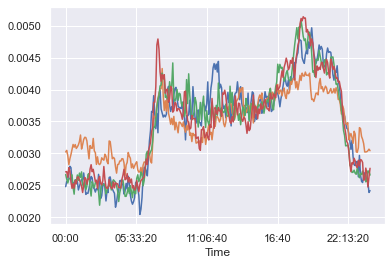

In [4]:
#Normalise Median Day
normalised_median = pd.DataFrame()
normalised_median['spring'] = spring_pivot['median'] / spring_pivot['median'].sum()
normalised_median['summer'] = summer_pivot['median'] / summer_pivot['median'].sum()
normalised_median['winter'] = winter_pivot['median'] / winter_pivot['median'].sum()
normalised_median['autumn'] = autumn_pivot['median'] / autumn_pivot['median'].sum()

normalised_median.spring.plot()
normalised_median.summer.plot()
normalised_median.winter.plot()
normalised_median.autumn.plot()

plt.show()

### Tariff Choices
There are 4 Tariff Categories Currently
<li> flat
<li> Time of Use (TOU)
<li> Flat with controlled Load
<li> TOU with controlled load

In [5]:
tariffs = tf.read_tariffs()

tariff_type = 'TOU'
tariff = None
for t in tariffs:
    if t.tariff_type == tariff_type:
        tariff = t

print("Tariff Name: " + tariff.tariff_name)


Tariff Name: OriginGo


In [6]:
import time
#generates a load based on average runtime and rated power
def generate_load(index, start_time):
    duration = pd.Timedelta(value=average_duration,unit='m')
    start_time = pd.Timestamp(index[0]) + pd.Timedelta(value=start_time * 5, unit='m')
    end_time = start_time + duration
    break_flag = False
    if end_time.date() > start_time.date():
        break_flag = True
    # print(end_time)
    y = pd.Series(np.zeros(len(index)), index = index)
    y[start_time:end_time] = (rated_power / 12) * 1000
    return y, break_flag

#TODO extract the actual load from the day
def extract_load(load, start_time):
    pass

from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('summer', (date(Y,  1,  1),  date(Y,  2, 29))),
           ('autumn', (date(Y,  3, 1),  date(Y,  5, 31))),
           ('winter', (date(Y,  6, 1),  date(Y,  8, 31))),
           ('spring', (date(Y,  9, 1),  date(Y, 11, 30))),
           ('summer', (date(Y, 12, 1),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [24]:
min_cost_load = pd.Series(dtype='float64')

start=time.time()
index = data['2019-01-01'].index
possible_loads = pd.DataFrame(index=index)
# print(possible_loads.index)
for i in range(int((24*60) / 5)):
    start_time = pd.Timestamp(possible_loads.index[0]) + pd.Timedelta(value=i * 5, unit='m')
    new_load, break_flag = generate_load(index, i)
    if break_flag: break
    new_load = new_load.rename(start_time.time())
    possible_loads = pd.concat([possible_loads, new_load], axis=1)

date_range = '2019-02'
days_in_set = data[date_range].index.date
days_in_set = np.unique(days_in_set)
start = time.time()
for day in days_in_set:
    date = str(day)
    print(date)
    season = get_season(day)
    total_use_sum = data[date].total_use.sum()
    if season == 'summer': total_use_without_load = normalised_median.summer * total_use_sum
    if season == 'winter': total_use_without_load = normalised_median.winter * total_use_sum
    if season == 'autumn': total_use_without_load = normalised_median.autumn * total_use_sum
    if season == 'spring': total_use_without_load = normalised_median.spring * total_use_sum
    # total_use_without_load = data[date].total_use - data[date].load
    # print(len(total_use_without_load))

    pv_day = data.PV[date]
    grid_import_cost = tariff.get_cost(data[date][['grid_import', 'load']] / 1000).sum()
    grid_export_revenue = data[date]['grid_export'] / 1000 * tariff.get_fit()
    # min_cost = grid_import_cost.sum() - grid_export_revenue.sum()
    min_cost = 10000
    max_time = 0
    max_load = data[date].load
    index = pd.date_range(pd.to_datetime(date+" 00:00:00"), periods=288, freq='5T')
    total_use_without_load.index = index

    # total_use_without_load.plot()
    # (data[date].total_use - data[date].load).plot()
    # plt.show()
    tariff_series = tariff.get_tariff_from_time_index(index.hour).astype(float)
    possible_loads.index = possible_loads.index.map(lambda x : x.replace(year=day.year, month=day.month, day=day.day))
    for col in possible_loads.columns:
        new_load = possible_loads.loc[:,col]
        new_total_use = total_use_without_load + new_load
        new_grid_import = (new_total_use - pv_day).clip(lower=0)
        new_grid_export = ((new_total_use - pv_day) * -1).clip(lower=0)
        new_grid_import_cost = (new_grid_import / 1000) * tariff_series
        new_grid_export_revenue = (new_grid_export / 1000) * tariff.get_fit()
        new_cost_net = new_grid_import_cost.sum(axis=0) - new_grid_export_revenue.sum(axis=0)
        # new_load.plot()
        if new_cost_net < min_cost:
            min_cost = new_cost_net
            max_load = new_load
            max_time = col

    min_cost_load = pd.concat([min_cost_load, max_load], axis=0)
print(time.time() - start)
print('done')

2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
13.543260335922241
done


In [25]:
data_copy = data[date_range].copy(deep=True)
# min_cost_data = apply_new_load(data_copy, min_cost_load)
new_load = min_cost_load[~min_cost_load.index.duplicated(keep='last')]
new_load = new_load.rename('load')
new_total_use = (data_copy.total_use - data_copy.load + new_load).rename('total_use')
new_AC = (new_total_use - data_copy.PV).rename('AC')
new_grid_import = new_AC.clip(lower=0).rename('grid_import')
new_grid_export = (new_AC * -1).clip(lower=0).rename('grid_export')
new_data = pd.concat([new_load, data_copy.PV, new_AC, new_total_use, new_grid_import, new_grid_export], axis=1)

# plotting old vs new

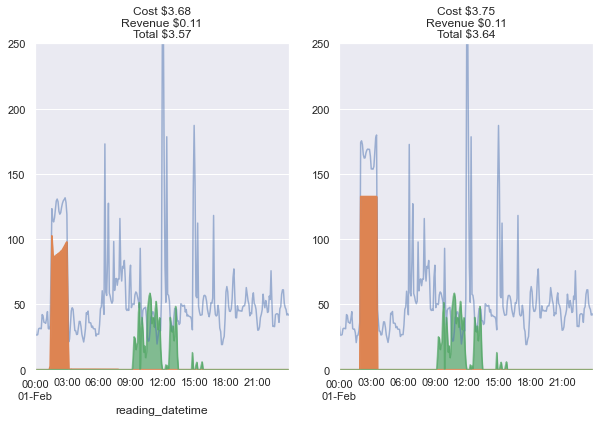

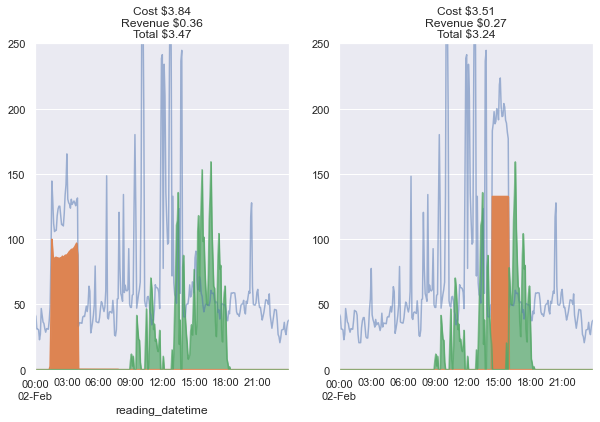

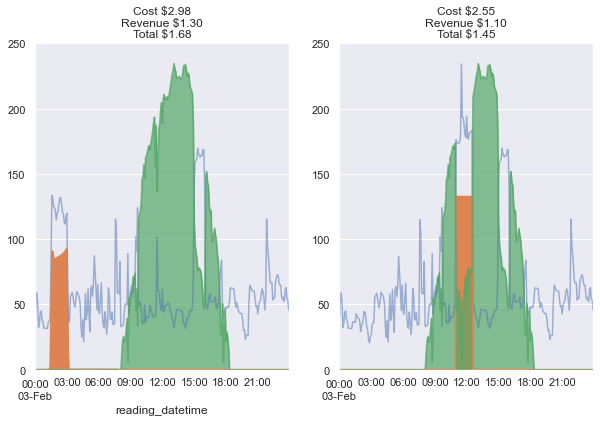

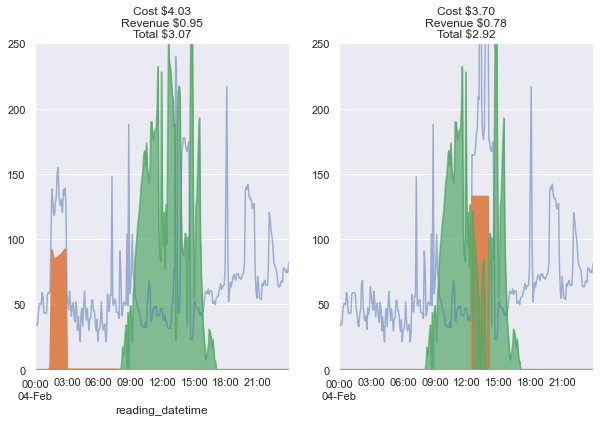

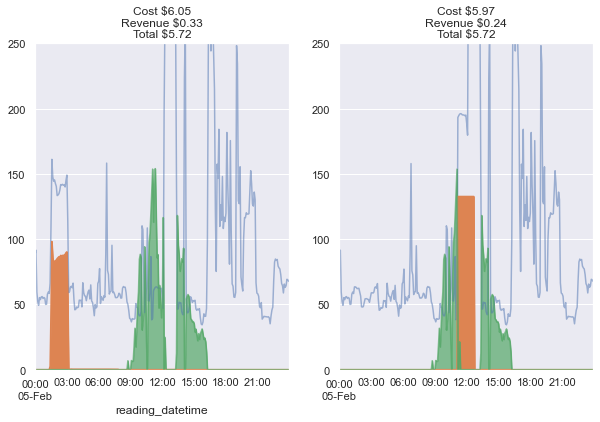

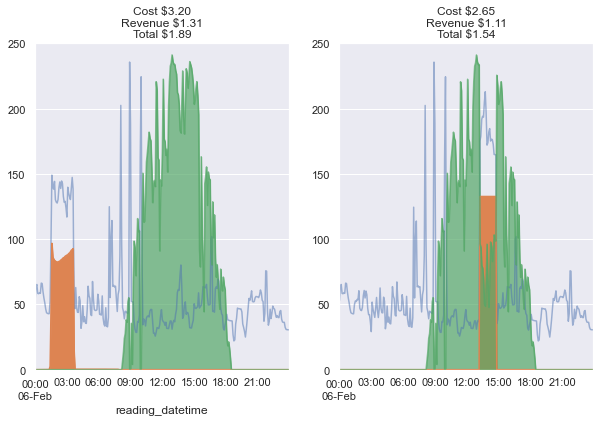

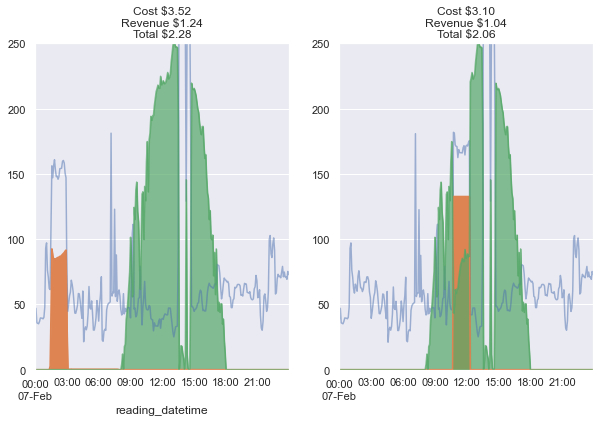

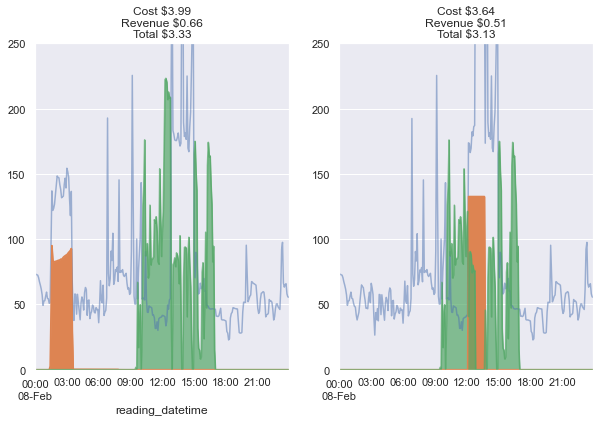

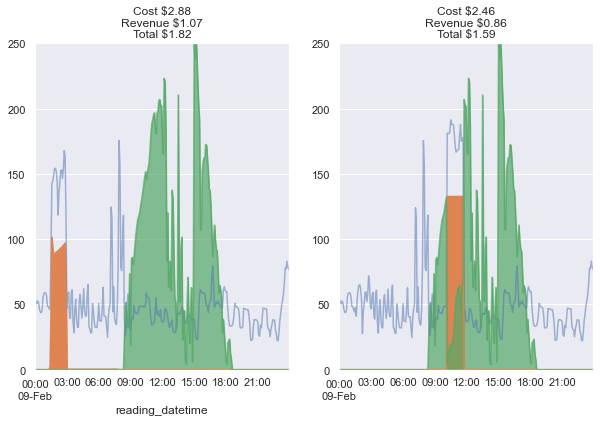

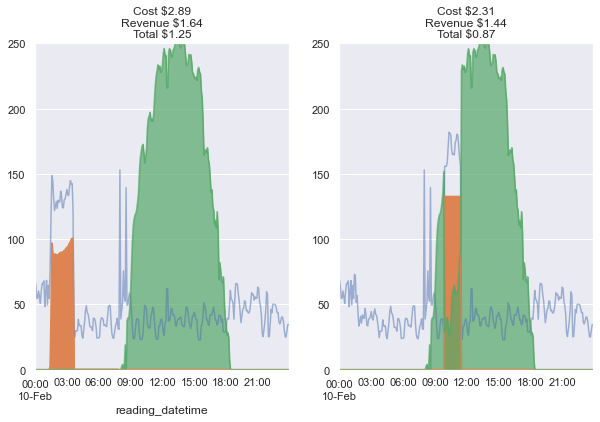

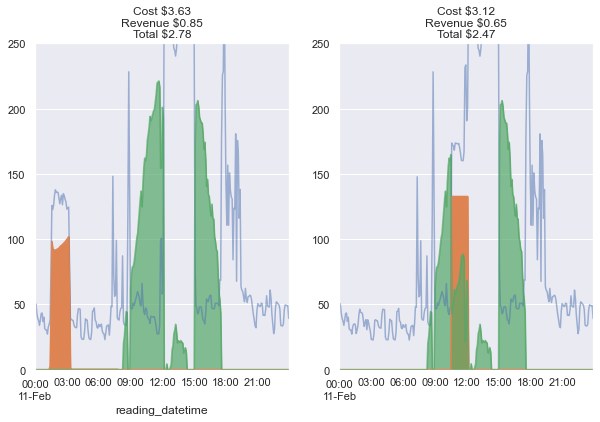

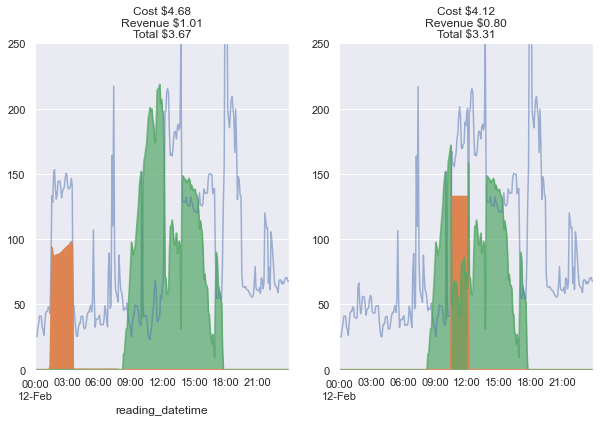

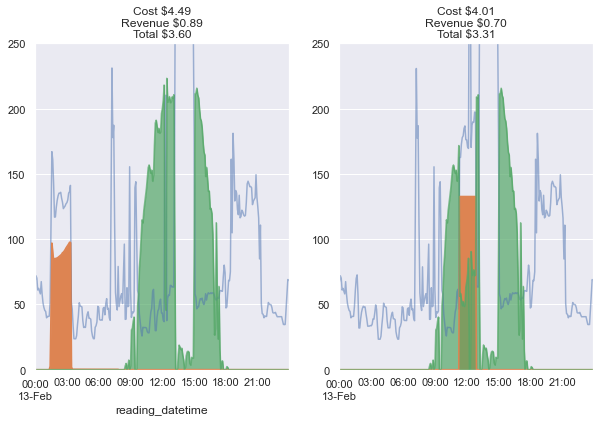

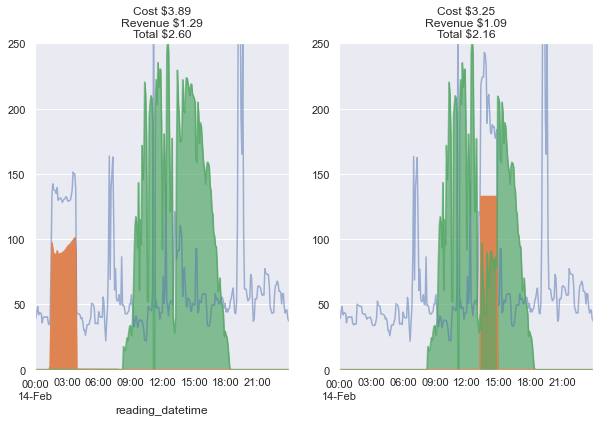

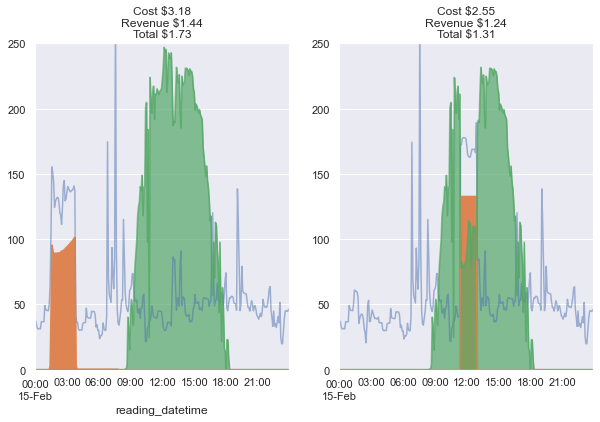

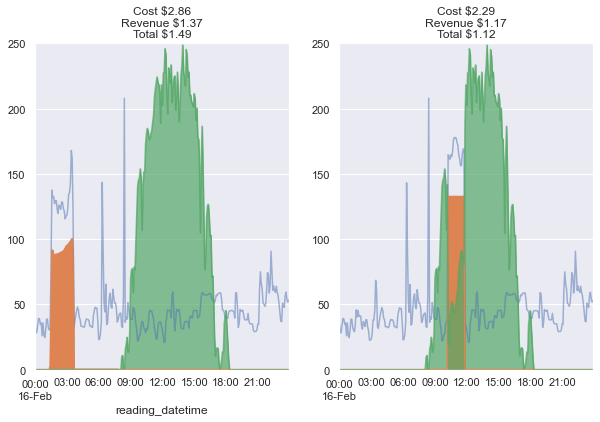

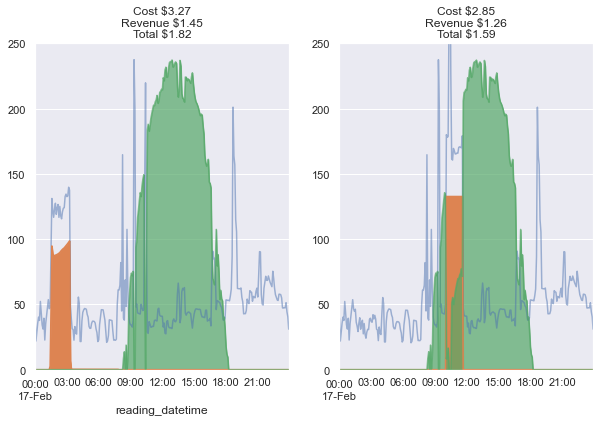

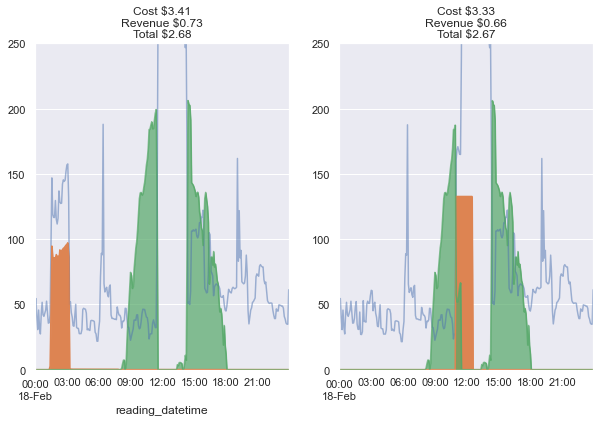

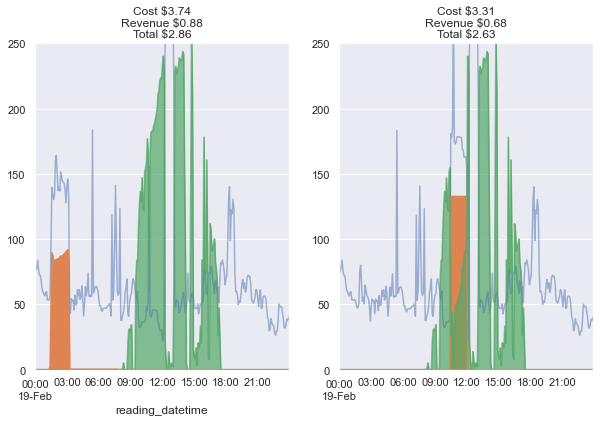

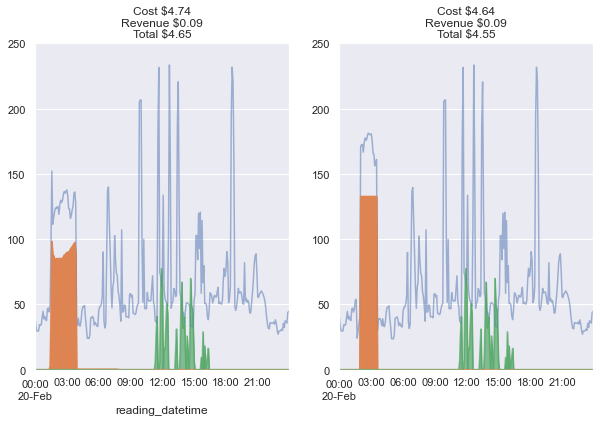

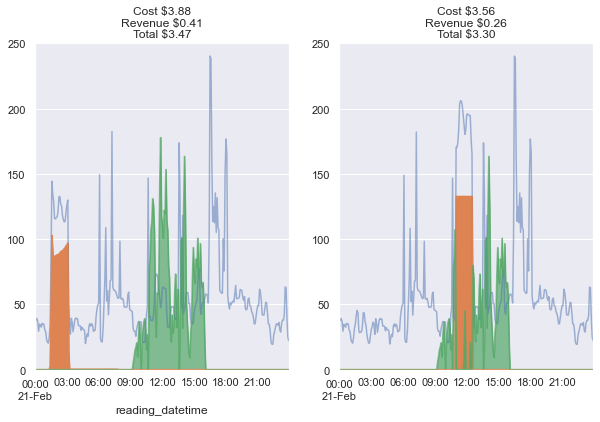

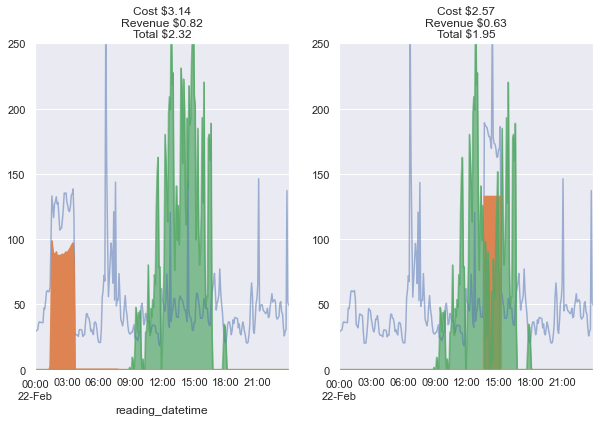

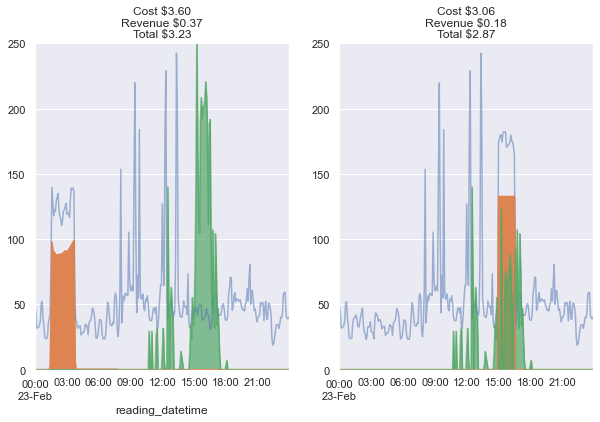

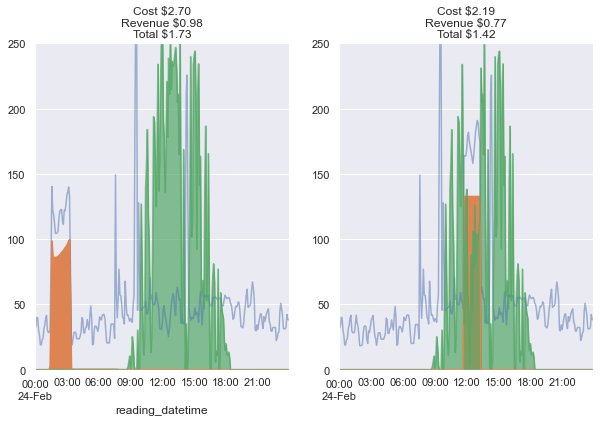

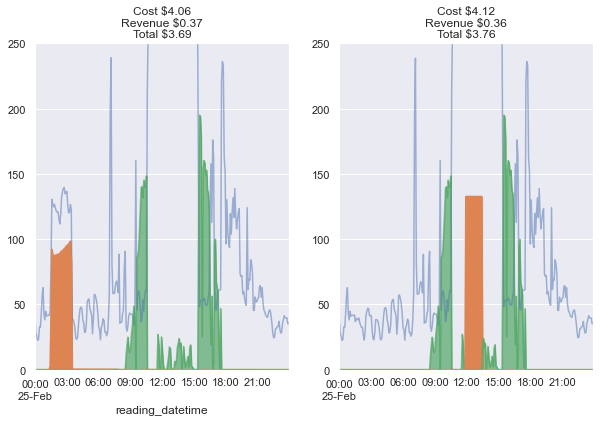

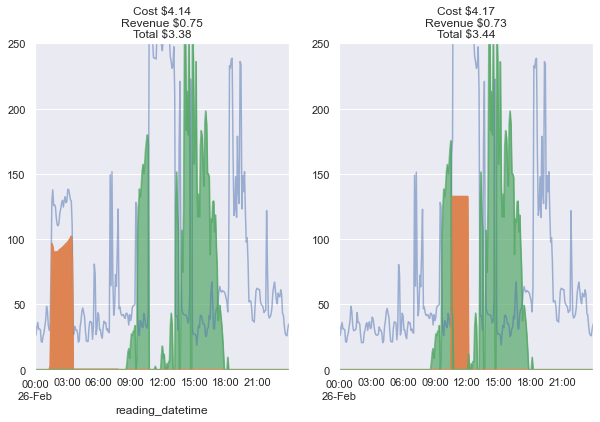

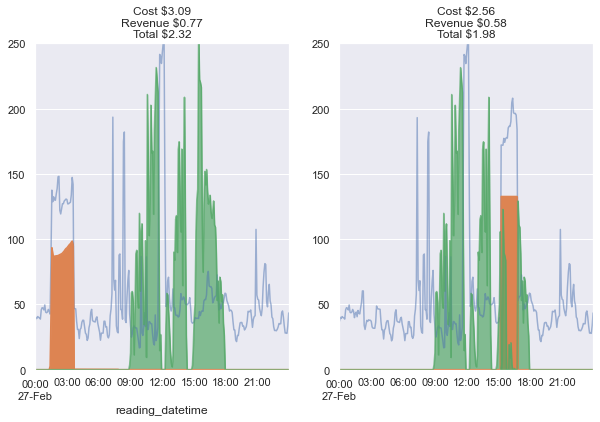

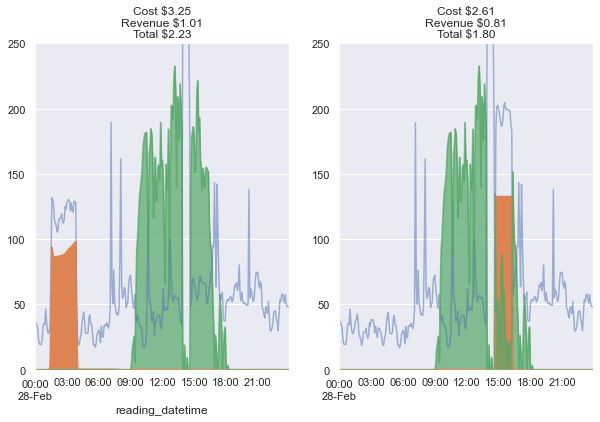

In [31]:
date = '2019-01-30'
days_in_set = data[date_range].index.date
days_in_set = np.unique(days_in_set)
for day in days_in_set:
    date = str(day)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
    data[date].total_use.plot(ax=ax[0], alpha=0.5)
    data[date].load.clip(lower=0).plot.area(ax=ax[0])
    data[date].grid_export.plot.area(ax=ax[0], alpha=0.7)
    cost = tariff.get_cost(data[date][['grid_import', 'load']]/1000).sum() / 100
    revenue = ((data[date].grid_export / 1000) * tariff.get_fit()).sum() / 100
    ax[0].set_title('Cost $%.2f\nRevenue $%.2f\nTotal $%.2f' % (cost, revenue, cost-revenue))
    ax[0].set_ylim([0,250])
    new_data[date].total_use.plot(ax=ax[1], alpha=0.5)
    new_data[date].load.clip(lower=0).plot.area(ax=ax[1])
    new_data[date].grid_export.plot.area(ax=ax[1], alpha=0.7)
    cost = tariff.get_cost(new_data[date][['grid_import', 'load']]/1000).sum() / 100
    revenue = ((new_data[date].grid_export / 1000) * tariff.get_fit()).sum() / 100
    ax[1].set_title('Cost $%.2f\nRevenue $%.2f\nTotal $%.2f' % (cost, revenue, cost-revenue))
    ax[1].set_ylim([0,250])
    plt.show()

In [32]:
print('Without Controlling Load')
house_consumption_total = data[date_range].total_use.sum() / 1000
pv_gen_total = data[date_range].PV.sum() / 1000
grid_import_total = data[date_range].grid_import.sum() / 1000
# grid_import_cost_total = data['2019-01'].grid
grid_export_total = data[date_range].grid_export.sum() / 1000
cost = tariff.get_cost(data[date_range][['grid_import', 'load']] / 1000)
revenue = data[date_range].grid_export / 1000 * tariff.get_fit()
cost_total = cost.sum() / 100
revenue_total = revenue.sum() / 100
# pv_utilisation_total = new_data['2019-01'].pv_utilisation.sum() /1000

# export = pv_net - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "${:.2f}".format(cost_total))
print("Export Revenue Cost\t\t" + "${:.2f}".format(revenue_total))
print("Net\t\t\t\t" + "${:.2f}".format(cost_total - revenue_total))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
# print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
# print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")


Without Controlling Load
House Usage Total		550.66kWh
Import total			320.87kWh
Export total			305.67kWh
Import Cost			$102.79
Export Revenue Cost		$24.45
Net				$78.34

PV total			535.45kWh


In [33]:
print('With Controlling Load')
house_consumption_total = new_data[date_range].total_use.sum() / 1000
pv_gen_total = new_data[date_range].PV.sum() / 1000
grid_import_total = new_data[date_range].grid_import.sum() / 1000
grid_export_total = new_data[date_range].grid_export.sum() / 1000
cost = tariff.get_cost(new_data[date_range][['grid_import', 'load']] / 1000)
revenue = new_data[date_range].grid_export / 1000 * tariff.get_fit()
cost_total = cost.sum() / 100
revenue_total = revenue.sum() / 100
# pv_utilisation_total = new_data['2019-01'].pv_utilisation.sum() /1000

# export = pv_net - pv_utilisation
# export_total = export.sum() / 1000

print("House Usage Total\t\t" + "{:.2f}".format(house_consumption_total) + "kWh")
print("Import total\t\t\t" + "{:.2f}".format(grid_import_total) + "kWh")
print("Export total\t\t\t" + "{:.2f}".format(grid_export_total) + "kWh")
print("Import Cost\t\t\t" + "${:.2f}".format(cost_total))
print("Export Revenue Cost\t\t" + "${:.2f}".format(revenue_total))
print("Net\t\t\t\t" + "${:.2f}".format(cost_total - revenue_total))
print()
print("PV total\t\t\t" + "{:.2f}".format(pv_gen_total) + "kWh")
# print("PV self consumed total\t\t" + "{:.2f}".format(pv_utilisation_total) + "kWh")
# print("PV exported\t\t\t" + "{:.2f}".format(export_total) + "kWh")
# print("PV utilisation\t\t\t" + "{:.2f}".format((pv_utilisation_total / pv_gen_total) * 100) + "%")


With Controlling Load
House Usage Total		561.68kWh
Import total			277.70kWh
Export total			251.48kWh
Import Cost			$91.91
Export Revenue Cost		$20.12
Net				$71.79

PV total			535.45kWh
